# Feature Analysis

This framework is used to analyse the audio signals (spoken words), usch that good features can be extracted to cluster them. 

# Imports

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm
# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
import pygsp

%matplotlib inline

plt.rcParams['figure.figsize'] = (17, 5)
pygsp.plotting.BACKEND = 'matplotlib'

2018-01-08 11:06:40,232:[WARNING](pygsp.graphs.nngraphs.nngraph.<module>): Cannot import pyflann (used for faster kNN computations): Traceback (most recent call last):
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pygsp\graphs\nngraphs\nngraph.py", line 14, in <module>
    import pyflann as pfl
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\__init__.py", line 27, in <module>
    from pyflann.index import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\index.py", line 27, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\bindings\__init__.py", line 30, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\bindings\flann_ctypes.py", line 171, in <module>
    raise ImportError('Cannot load dynamic library. Did you compile FLANN?')
ImportError: Cannot load dynamic library. Did you compile FLANN?



## 1. Import the Data
----
Use `N` random samples for each word.

In [2]:
N = 2

train_audio_path = '../Data/train/audio'
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()

path = []
word = []
speaker = []
iteration = []

for direct in dirs:
    if not direct.startswith('_'):
        # Random selection of N files per folder 
        list_files = os.listdir(join(train_audio_path, direct))
        wave_selected  = list(np.random.choice([ f for f in list_files if f.endswith('.wav')],N,replace=False))
        
        # Extraction of file informations for dataframe
        word.extend(list(np.repeat(direct,N,axis=0)))
        speaker.extend([wave_selected[f].split('.')[0].split('_')[0] for f in range(N) ])
        iteration.extend([wave_selected[f].split('.')[0].split('_')[-1] for f in range(N) ])
        path.extend([train_audio_path + '/' + direct + '/' + wave_selected[f] for f in range(N)])

Initialize the dataframe of the original data

In [3]:
features_og = pd.DataFrame({('info','word',''): word,
                            ('info','speaker',''): speaker,
                            ('info','iteration',''): iteration,
                            ('info','path',''): path})
index_og = [('info','word',''),('info','speaker',''),('info','iteration','')]
#features_og.set_index(index_og,inplace=True)
features_og.head()

info                                                                
  iteration                                            path   speaker  word
                                                                           
0         0   ../Data/train/audio/bed/dedc7fab_nohash_0.wav  dedc7fab   bed
1         0   ../Data/train/audio/bed/06076b6b_nohash_0.wav  06076b6b   bed
2         0  ../Data/train/audio/bird/1995cf9e_nohash_0.wav  1995cf9e  bird
3         0  ../Data/train/audio/bird/3a7d8872_nohash_0.wav  3a7d8872  bird
4         0   ../Data/train/audio/cat/6094340e_nohash_0.wav  6094340e   cat

## 2. Features Extraction
----
### 2.1 MFCC
A classical but reliable set of features

In [4]:
N_MFCC = 20

def compute_mfcc(filepath):
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
    return librosa.feature.mfcc(y=audio,sr=sampling_rate)

In [5]:
stat_name= ['mean','std','skew','kurtosis','median']
col_names = [('mfcc',stat_name[i],j) for i in range(len(stat_name))  for j in range(N_MFCC)]
features_mfcc =pd.DataFrame(columns=pd.MultiIndex.from_tuples(col_names),index=features_og.index)
# sorting the columns in order to improve index performances (see lexsort errors)
features_mfcc.sort_index(axis=1,inplace=True,sort_remaining=True)

# MFCC FEATURES :
for w in tqdm(range(len(features_og)),total=len(features_og),unit='waves'):
    mfcc = compute_mfcc(features_og[('info','path')].iloc[w])
    features_mfcc.loc[w, ('mfcc', 'mean')] = np.mean(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'std')] = np.std(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'skew')] = scipy.stats.skew(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'kurtosis')] = scipy.stats.kurtosis(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'median')] = np.median(mfcc,axis=1)
    
features_og = features_og.merge(features_mfcc,left_index=True,right_index=True)
features_og.head()

100%|██████████| 60/60 [00:02<00:00, 21.10waves/s]


info                                                                  \
  iteration                                            path   speaker  word   
                                                                              
0         0   ../Data/train/audio/bed/dedc7fab_nohash_0.wav  dedc7fab   bed   
1         0   ../Data/train/audio/bed/06076b6b_nohash_0.wav  06076b6b   bed   
2         0  ../Data/train/audio/bird/1995cf9e_nohash_0.wav  1995cf9e  bird   
3         0  ../Data/train/audio/bird/3a7d8872_nohash_0.wav  3a7d8872  bird   
4         0   ../Data/train/audio/cat/6094340e_nohash_0.wav  6094340e   cat   

       mfcc                                                     ...     \
   kurtosis                                                     ...      
          0         1         2         3         4         5   ...      
0  -1.52804  -1.51959 -0.202959  -1.51804  -1.71856 -0.508457   ...      
1 -0.192953  0.214862  0.149259   -1.0446  0.999391 -0.281967   ...      
2  -1.41834  -1.19697   1.00012 -0.343681 -0.450743  0.352598   ...      
3  -1.43428  -1.11721  -1.36081  0.154062  0.510223 -0.556318   ...      
4   0.15029   2.98296   1.85597   1.42591 -0.659255   1.25027   ...      

                                                                           \
       std                                                                  
        10       11       12       13       14       15       16       17   
0  6.51601  13.4821  11.4434  9.54684  4.49095   8.5928  13.1557  7.36256   
1  6.61524  6.58129  4.33423  11.7914  8.71559  5.38666  6.79552  9.94194   
2  5.42847   8.4303  2.45618  3.66697  3.15011  5.42234  4.68986  3.94322   
3  12.5195  7.76836  6.08526  3.53717  10.7559  3.69663  8.57944  4.70762   
4  6.21956  7.49575  4.68085  6.04493  6.10778  5.28297  5.17408  3.97891   

                     
                     
        18       19  
0  6.21733  5.93979  
1  6.14195   4.5516  
2  7.09214  4.16214  
3  4.94176  2.90474  
4   4.7244  3.75144  

[5 rows x 104 columns]

## Signal Analysis

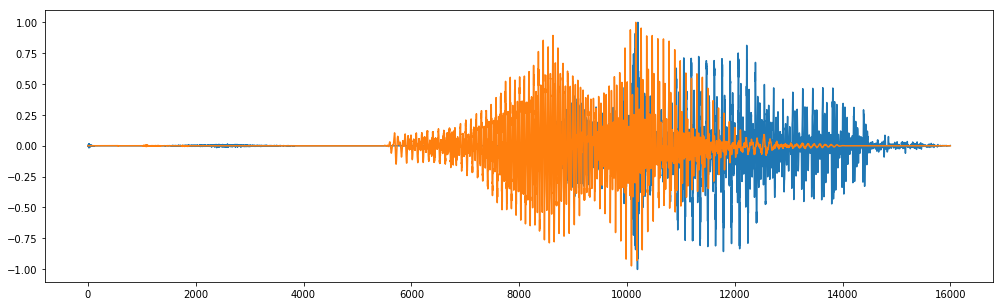

In [6]:
word_1 = 58
word_2 = 59
def get_audio(filepath):
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
    return audio, sampling_rate

audio_1, sampling_rate_1 = get_audio(features_og[('info','path')].iloc[word_1])
audio_2, sampling_rate_2 = get_audio(features_og[('info','path')].iloc[word_2])

# normalize audio signals
audio_1 = audio_1/np.max(audio_1)
audio_2  = audio_2/np.max(audio_2)

# Look at the signal in the time domain
plt.plot(audio_1)
plt.hold
plt.plot(audio_2)

# Listen to the first word
ipd.Audio(data=audio_1, rate=sampling_rate_1)

In [278]:
# Listen to second word
ipd.Audio(data=audio_2, rate=sampling_rate_2)

## From audio signal to distance 

Compute RMSE of both signals and display it.

In [279]:
def find_mainlobe(Thresh, audio,):
    # Compute rmse
    rmse_audio = librosa.feature.rmse(audio, hop_length = 1, frame_length=int(2048/8)).reshape(-1,)
    
    i_start = np.array([])
    i_end = np.array([])
    for i in range(len(rmse_audio)-1):
        if (int(rmse_audio[i]>Thresh)-int(rmse_audio[i+1]>Thresh)) == -1:
            i_start = np.append(i_start,i)
        elif (int(rmse_audio[i]>Thresh)-int(rmse_audio[i+1]>Thresh)) == 1:    
            i_end = np.append(i_end,i)
    
    if len(i_start) == 0:
        i_start = np.append(i_start,0)
        
    if len(i_end) == 0:
        i_end = np.append(i_end,i)   
    
    if i_start[0]>i_end[0]:
        i_start = np.append(np.array(0), i_start)
        
    if i_start[-1]>i_end[-1]:
        i_end = np.append(i_end,i)

    # Evualuate longest lobe
    lengths = i_end -i_start

    audio_cut = audio[int(i_start[np.argmax(lengths)]-int(2048/16)):int(i_end[np.argmax(lengths)]-int(2048/16))]
    print(int(i_start[np.argmax(lengths)]-int(2048/16)))
    print(int(i_end[np.argmax(lengths)]-int(2048/16)))
    return audio_cut

In [280]:
def find_lobes(Thresh, audio, shift = int(2048/16) ):
    # Compute rmse
    audio = audio/np.max(audio)
    rmse_audio = librosa.feature.rmse(audio, hop_length = 1, frame_length=int(shift*2)).reshape(-1,)
    rmse_audio -= np.min(rmse_audio)
    i_start = np.array([])
    i_end = np.array([])
    for i in range(len(rmse_audio)-1):
        if (int(rmse_audio[i]>Thresh)-int(rmse_audio[i+1]>Thresh)) == -1:
            i_start = np.append(i_start,i)
        elif (int(rmse_audio[i]>Thresh)-int(rmse_audio[i+1]>Thresh)) == 1:    
            i_end = np.append(i_end,i)
    
    if len(i_start) == 0:
        i_start = np.append(i_start,0)
        
    if len(i_end) == 0:
        i_end = np.append(i_end,i)   
    
    if i_start[0]>i_end[0]:
        i_start = np.append(np.array(0), i_start)
        
    if i_start[-1]>i_end[-1]:
        i_end = np.append(i_end,i)
    
    return i_start, i_end, rmse_audio, shift

In [281]:
def cut_signal( audio, Thresh = 0.01, mode = 'proxy',reach = 2000, number_lobes = 2):
    
    i_start, i_end, rmse_audio, shift = find_lobes(Thresh, audio)
    energy = np.array([])
    for i in range(len(i_start)):
        energy = np.append(energy,sum(rmse_audio[int(i_start[i]):int(i_end[i])]))
    
    if mode is 'num_lobes':
        lobes = np.argsort(energy)[-number_lobes:]
        start = np.min(i_start[lobes])
        end = np.max(i_end[lobes])
    elif mode is 'proxy':
        main_lobe = np.argsort(energy)[-1]
        start = i_start[main_lobe]
        end = i_end[main_lobe]
        
        for i in range(main_lobe):
            if (i_start[main_lobe]-i_end[i])<reach:
                start = np.min((i_start[i],start))
                
        for i in range(main_lobe,len(i_start)):   
            if (i_start[i]-i_end[main_lobe])<reach:
                end = i_end[i]
        
    else:
        print('ERROR: mode not implemented.')
        
    audio_cut = audio[int(np.max((0,int(start-shift-300)))):int(np.min((int(end)+300,len(audio))))]    
    return audio_cut


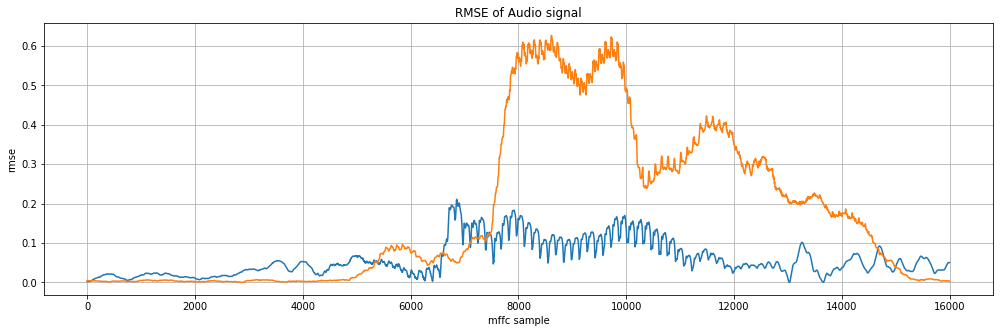

In [282]:
rmse_audio_1 = librosa.feature.rmse(audio_1, hop_length = 1, frame_length=int(2048/8)).reshape(-1,)
rmse_audio_1 -= np.min(rmse_audio_1)
plt.plot(rmse_audio_1)
plt.grid()
plt.title('RMSE of Audio signal')
plt.xlabel('mffc sample')
plt.ylabel('rmse')
plt.hold
rmse_audio_2 = librosa.feature.rmse(audio_2, hop_length = 1,  frame_length=int(2048/8)).reshape(-1,)
rmse_audio_2 -= np.min(rmse_audio_2)
plt.plot(rmse_audio_2)

1821
15999
4453
15263
(11110,)


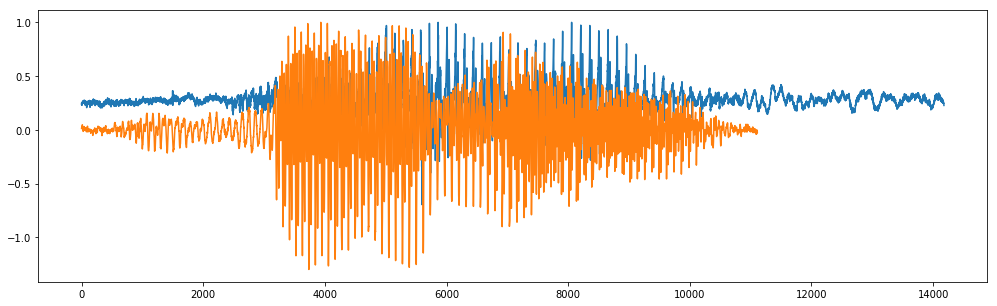

In [283]:
# just keep stuff above threshold
Thresh = 0.01

audio_1_cut = cut_signal(Thresh,audio_1,reach = 2000)

audio_2_cut = cut_signal(Thresh,audio_2,reach = 2000)

print(np.shape(audio_2_cut))
# Display cut time signal
plt.plot(audio_1_cut)
plt.hold
plt.plot(audio_2_cut)
ipd.Audio(data=audio_1_cut, rate=sampling_rate_1)

In [284]:
ipd.Audio(data=audio_2_cut, rate=sampling_rate_2)

In [8]:
from cut_audio import *

cut_1_audio = cut_signal(audio_1)
ipd.Audio(data=cut_1_audio, rate=sampling_rate_1)